##Forecasting ARIMA dan SARIMA Modal Usaha

##Install Library

In [51]:
%pip install statsmodels openpyxl

##Import Library

In [52]:
import pandas as pd                             # Untuk manipulasi data (DataFrame)
import numpy as np                              # Operasi numerik
import matplotlib.pyplot as plt                 # Visualisasi grafik
from statsmodels.tsa.stattools import adfuller  # ADF test untuk stasioneritas
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
                                                # Plot ACF & PACF
from statsmodels.tsa.arima.model import ARIMA   # Fitting model ARIMA
from sklearn.metrics import (
    mean_absolute_error,                        # MAE
    mean_squared_error                          # RMSE (via sqrt MSE)
)

#Pre-Processing Data

In [53]:
df = pd.read_excel('/content/Arima_Tiap Bulan.xlsx')     # Baca Excel ke DataFrame
df['Bulan Tahun'] = pd.to_datetime(df['Bulan Tahun'])         # Pastikan kolom tanggal bertipe datetime
              # Jadikan kolom Date sebagai indeks

In [54]:
# Lihat sekilas struktur
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Bulan Tahun  32 non-null     datetime64[ns]
 1   Modal Usaha  32 non-null     int64         
 2   Rombong      32 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 900.0 bytes
None


In [55]:
df.head()

,Bulan Tahun,Modal Usaha,Rombong
0,2022-05-01,145300000,274000000
1,2022-06-01,112000000,199500000
2,2022-07-01,180700000,310000000
3,2022-08-01,98500000,228300000
4,2022-09-01,201000000,342000000


In [56]:
print(df.isnull().sum()) #Cek Apakah ada Missing Value (Data Kosong)

Bulan Tahun    0
Modal Usaha    0
Rombong        0
dtype: int64


In [57]:
print(df.index.duplicated().sum()) #Cek Apakah ada Data Duplicate

0


In [58]:
df.shape # Ukuran data terdapat 34 entry data dan 2 kolom

(32, 3)

In [59]:
df.columns # Terdapat Kolom  Bulan Tahun dan Modal Usaha

Index(['Bulan Tahun', 'Modal Usaha', 'Rombong'], dtype='object')

In [60]:
df.info() # Tipe data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Bulan Tahun  32 non-null     datetime64[ns]
 1   Modal Usaha  32 non-null     int64         
 2   Rombong      32 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 900.0 bytes


In [61]:
df.head() #data setelah yang diperlukan

,Bulan Tahun,Modal Usaha,Rombong
0,2022-05-01,145300000,274000000
1,2022-06-01,112000000,199500000
2,2022-07-01,180700000,310000000
3,2022-08-01,98500000,228300000
4,2022-09-01,201000000,342000000


##Pemeriksaan Stasioneritas Dataset

In [62]:
def adf_test(series):
    result = adfuller(series)
    adf_statistic = round(result[0], 2)  # Membatasi ADF Statistic hingga 2 angka desimal
    p_value = round(result[1], 2)        # Membatasi p-value hingga 2 angka desimal
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    if p_value <= 0.05:
        print("Data stasioner")
    else:
        print("Data tidak stasioner")

adf_test(df['Modal Usaha'])
adf_test(df['Rombong'])

ADF Statistic: -8.81
p-value: 0.0
Data stasioner
ADF Statistic: -6.9
p-value: 0.0
Data stasioner


Jika data tidak stasioner (p-value > 0.05), Anda harus melakukan differencing pada data tersebut sebelum digunakan dalam model ARIMA.

##Visualisasi Dataset


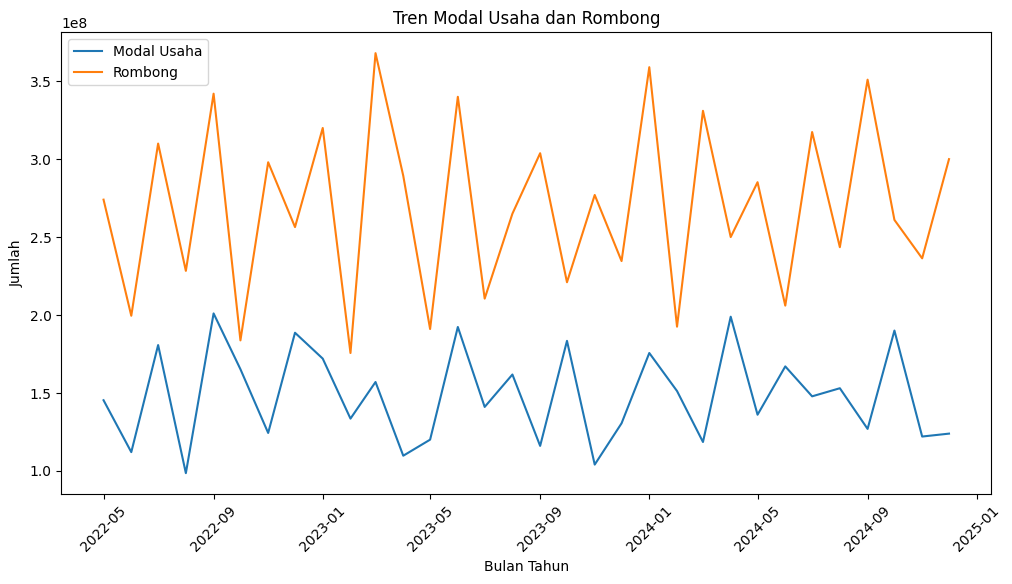

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(df['Bulan Tahun'], df['Modal Usaha'], label='Modal Usaha')
plt.plot(df['Bulan Tahun'], df['Rombong'], label='Rombong')
plt.legend()
plt.title('Tren Modal Usaha dan Rombong')
plt.xlabel('Bulan Tahun')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

In [64]:
correlation_matrix = df[['Modal Usaha', 'Rombong']].corr()
print(correlation_matrix)

             Modal Usaha   Rombong
Modal Usaha     1.000000  0.168456
Rombong         0.168456  1.000000


# 1. Forecasting Jenis Modal Usaha


##Visualisasi Data Modal Usaha

In [65]:
df = df.drop(columns = 'Rombong') # Hapus baris Modal Usaha karena ingin Menganalisis Modal Usaha terlebih dahulu
df.head() # Menampilkan 5 baris teratas

,Bulan Tahun,Modal Usaha
0,2022-05-01,145300000
1,2022-06-01,112000000
2,2022-07-01,180700000
3,2022-08-01,98500000
4,2022-09-01,201000000


##Split Data Train 90 Test 10

In [66]:
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]

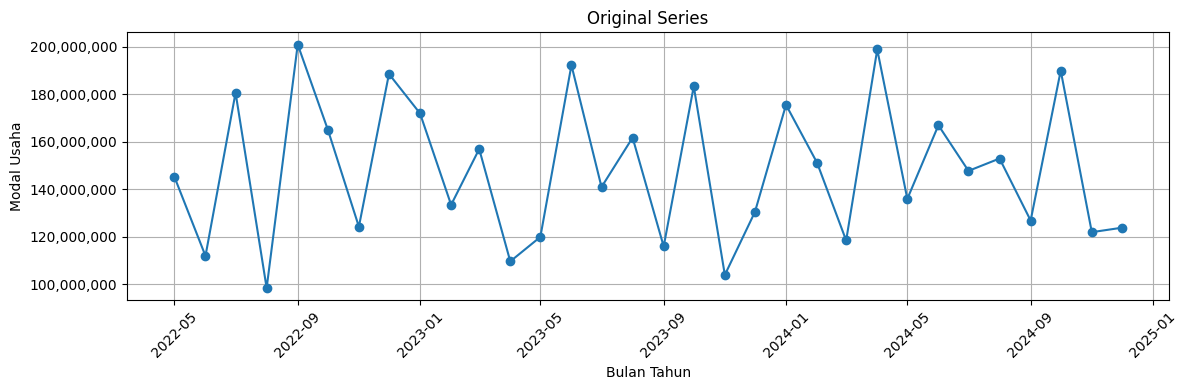

In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 4))

# Plot
plt.plot(df['Bulan Tahun'], df['Modal Usaha'], marker='o')
plt.title('Original Series')
plt.xlabel('Bulan Tahun')
plt.ylabel('Modal Usaha')
plt.grid(True)

# Format angka di sumbu Y tanpa notasi ilmiah
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Cek kestasioneran secara visual:

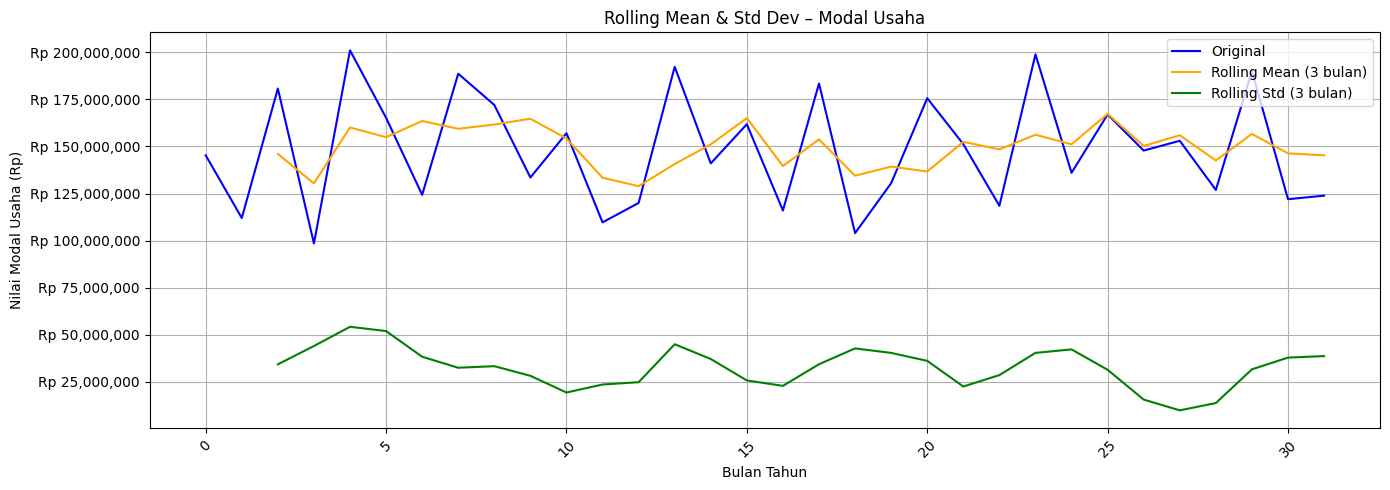

In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Hitung rolling mean dan std dev
rolmean = df['Modal Usaha'].rolling(window=3).mean()
rolstd = df['Modal Usaha'].rolling(window=3).std()

# Plot hasil
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Modal Usaha'], label='Original', color='blue') # Use df.index for x-axis
plt.plot(df.index, rolmean, label='Rolling Mean (3 bulan)', color='orange') # Use df.index for x-axis
plt.plot(df.index, rolstd, label='Rolling Std (3 bulan)', color='green') # Use df.index for x-axis

# Tambahkan label dan format sumbu Y
plt.title('Rolling Mean & Std Dev – Modal Usaha')
plt.xlabel('Bulan Tahun')
plt.ylabel('Nilai Modal Usaha (Rp)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Format Y jadi format Rupiah (Rp)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x:,.0f}'))

plt.tight_layout()
plt.show()

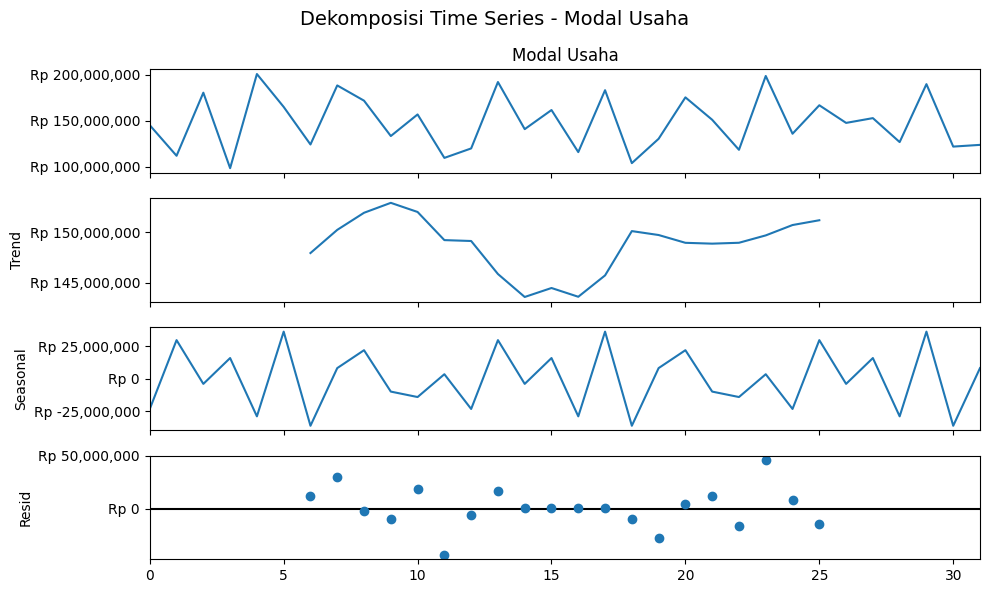

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Pastikan kolom tanggal jadi index
# df = df.set_index('Bulan Tahun') # Removed this line

# Decompose (gunakan model 'additive' atau 'multiplicative')
result = seasonal_decompose(df['Modal Usaha'], model='additive', period=12)

# Plot
fig = result.plot()
fig.set_size_inches(10, 6)

# Format sumbu Y jadi Rupiah
for ax in fig.axes:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x:,.0f}'))

plt.suptitle('Dekomposisi Time Series - Modal Usaha', fontsize=14)
plt.tight_layout()
plt.show()

Visualisasi data menunjukkan pola musiman (seasonal pattern) maka gunakan arima dan sarima (p,d,q)

##Uji ADF (Augmented Dickey-Fuller Test)

In [70]:
result = adfuller(df['Modal Usaha'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# Jika p-value > 0.05, lakukan differencing

ADF Statistic: -8.806880
p-value: 0.000000


p-value < 0.05 → berarti data sudah stasioner secara statistik dan ADF Statistic yang sangat negatif

##Plot ACF untuk menentukan nilai q

In [71]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

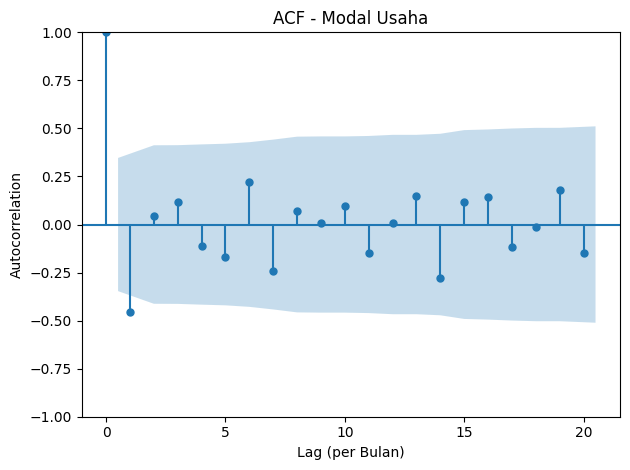

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Modal Usaha'], lags=20)
plt.title('ACF - Modal Usaha')
plt.xlabel('Lag (per Bulan)')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

Grafik ACF menunjukkan bahwa autokorelasi hanya signifikan pada lag ke-1 dan menurun drastis setelahnya. Ini mengindikasikan bahwa efek memori jangka pendek (moving average) dalam data Modal Usaha relatif rendah, sehingga pemilihan nilai q = 1 untuk model ARIMA cukup tepat.

Pola Terpotong (Cut Off): Untuk menentukan nilai q dari plot ACF, kita mencari pola di mana korelasi "terpotong" atau tiba-tiba jatuh menjadi tidak signifikan.

Ada satu lonjakan (spike) yang sangat signifikan pada Lag 1, yang jelas keluar dari area biru (selang kepercayaan)

Setelah Lag 1, lonjakan pada lag 2, 3, 4, dan 5 langsung jatuh ke dalam area biru, yang berarti korelasinya tidak lagi signifikan

Pola yang terpotong secara jelas setelah Lag 1 ini adalah ciri khas dari model Moving Average orde 1 (MA(1)) atau q 1

###Plot PACF untuk menentukan nilai p

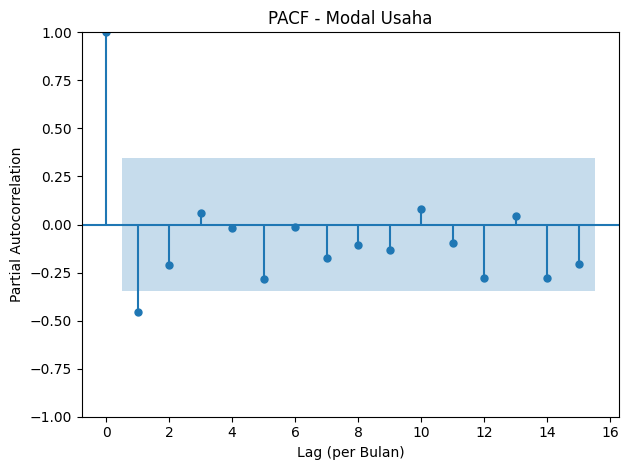

In [73]:
plot_pacf(df['Modal Usaha'], lags=15)
plt.title('PACF - Modal Usaha')
plt.xlabel('Lag (per Bulan)')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()

Untuk mengetahui berapa lag yang memiliki pengaruh langsung (signifikan) terhadap nilai saat ini. Ini digunakan untuk menentukan parameter AR (Auto-Regressive) = p dalam model ARIMA.

Karena hanya lag-1 yang signifikan secara signifikan Berada di luar area biru (confidence interval)

Model ARIMA yang cocok untuk komponen AR-nya adalah p = 1

Hasil grafik PACF menunjukkan autokorelasi parsial yang signifikan hanya pada lag ke-1, dengan nilai yang negatif dan berada di luar batas kepercayaan. Ini menunjukkan bahwa struktur autoregressive dalam data cukup ditangkap oleh AR(1), sehingga model ARIMA yang sesuai adalah dengan parameter p = 1

Sehingga Parameter ARIMA (Dari ACF, PACF, ADF)
p 1 Dari PACF,
d 0 Dari ADF Test,
q 1 Dari ACF

#Bangun Model SARIMA Model Terbaik(Jenis Modal Usaha)

##1. Import Library

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

##2. Persiapkan Data dan Split 90:10

In [75]:
df['Bulan Tahun'] = pd.to_datetime(df['Bulan Tahun'])
df = df.set_index('Bulan Tahun')

# Split 90% data untuk training, 10% untuk testing
n = int(len(df) * 0.9)
train = df.iloc[:n]
test = df.iloc[n:]

##3. Konfigurasi dan Latih Semua Model SARIMA

In [76]:
model_configs = [
    {"name": "SARIMA_101_111_12", "order": (1, 0, 1), "seasonal_order": (1, 1, 1, 12)},
    {"name": "SARIMA_101_010_12", "order": (1, 0, 1), "seasonal_order": (0, 1, 0, 12)},
    {"name": "SARIMA_102_010_12", "order": (1, 0, 2), "seasonal_order": (0, 1, 0, 12)},
    {"name": "SARIMA_101_011_12", "order": (1, 0, 1), "seasonal_order": (0, 1, 1, 12)},
    {"name": "SARIMA_101_100_12", "order": (1, 0, 1), "seasonal_order": (1, 0, 0, 12)},
]

results = []

for cfg in model_configs:
    try:
        model = SARIMAX(train['Modal Usaha'],
                        order=cfg['order'],
                        seasonal_order=cfg['seasonal_order'],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        result = model.fit(disp=False)
        results.append({
            "Model": cfg["name"],
            "AIC": result.aic,
            "Result": result,
            "Order": cfg["order"],
            "Seasonal": cfg["seasonal_order"]
        })
    except Exception as e:
        print(f"Model {cfg['name']} gagal: {e}")


##4. Pilih Model Terbaik (AIC Terkecil)

In [77]:
results_sorted = sorted(results, key=lambda x: x["AIC"])
best_model = results_sorted[0]

print("📊 Ringkasan AIC Model SARIMA:")
for r in results_sorted:
    print(f"{r['Model']:25} AIC = {r['AIC']:.2f}")


📊 Ringkasan AIC Model SARIMA:
SARIMA_101_011_12         AIC = 81.66
SARIMA_101_111_12         AIC = 83.66
SARIMA_102_010_12         AIC = 502.22
SARIMA_101_010_12         AIC = 534.84
SARIMA_101_100_12         AIC = 578.13


##5. Forecast 12 Bulan ke Depan dan Visualisasi

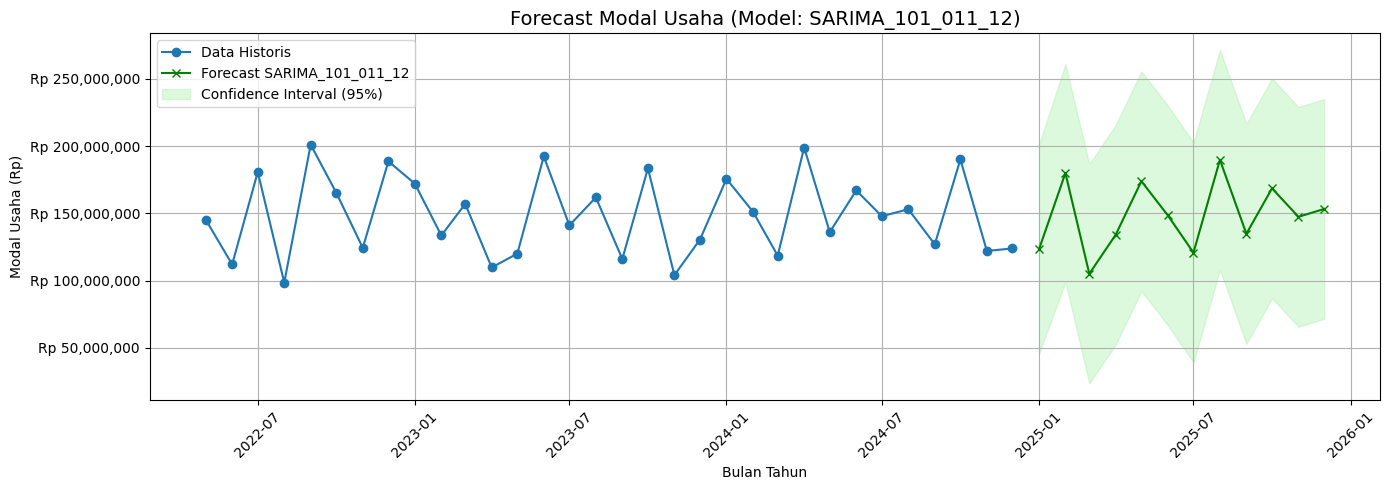

In [78]:
# Forecast 12 bulan ke depan
forecast_result = best_model["Result"].get_forecast(steps=12)
y_pred = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Buat index waktu ke depan
# Get the last date from the 'Bulan Tahun' column (which is a datetime object)
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
y_pred.index = future_index
conf_int.index = future_index

# Visualisasi
plt.figure(figsize=(14, 5))
# Plot data historis using 'Bulan Tahun' column as x-axis
plt.plot(df.index, df['Modal Usaha'], label='Data Historis', marker='o')
plt.plot(y_pred.index, y_pred, label=f"Forecast {best_model['Model']}", color='green', marker='x')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0].clip(lower=0),
                 conf_int.iloc[:, 1].clip(lower=0),
                 color='lightgreen', alpha=0.3, label='Confidence Interval (95%)')

# Format Rupiah
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x:,.0f}'))

plt.title(f"Forecast Modal Usaha (Model: {best_model['Model']})", fontsize=14)
plt.xlabel("Bulan Tahun")
plt.ylabel("Modal Usaha (Rp)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##6. Tampilkan Tabel Forecast

In [79]:
# Buat DataFrame hanya dengan kolom Bulan Tahun dan hasil Forecast
forecast_df = pd.DataFrame({
    'Bulan Tahun': future_index.strftime('%Y-%m'),
    'Forecast (Rp)': y_pred.values
})

# Fungsi untuk format ke Rupiah
def format_rupiah(x):
    return f"Rp {x:,.0f}".replace(",", ".")

# Terapkan format Rupiah ke kolom Forecast
forecast_df['Forecast (Rp)'] = forecast_df['Forecast (Rp)'].apply(format_rupiah)

# Tampilkan tabel forecast
print("\n📋 Tabel Forecast 12 Bulan ke Depan:")
print(forecast_df.to_string(index=False))


📋 Tabel Forecast 12 Bulan ke Depan:
Bulan Tahun  Forecast (Rp)
    2025-01 Rp 123.095.108
    2025-02 Rp 179.877.640
    2025-03 Rp 105.014.440
    2025-04 Rp 134.163.398
    2025-05 Rp 173.846.379
    2025-06 Rp 148.413.552
    2025-07 Rp 120.723.787
    2025-08 Rp 189.736.979
    2025-09 Rp 134.741.384
    2025-10 Rp 168.535.728
    2025-11 Rp 147.380.940
    2025-12 Rp 153.190.423


##7. Evaluasi Model dengan Data Test

In [80]:
# Gunakan test set sebagai evaluasi
y_true = test['Modal Usaha'].values
y_pred_test = best_model["Result"].get_forecast(steps=len(test)).predicted_mean.values

mae = mean_absolute_error(y_true, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_test))
mape = np.mean(np.abs((y_true - y_pred_test) / y_true)) * 100

print(f"\n📈 Evaluasi Model {best_model['Model']}:")
print(f"Nilai Rata-rata kesalahan absolut dalam prediksi (MAE)                                  : {mae:,.0f}".replace(",", "."))
print(f"Nilai Rata-rata dari selisih antara nilai prediksi dan nilai aktual (RMSE)              : {rmse:,.0f}".replace(",", "."))
print(f"Presentase Nilai Rata-rata dari selisih antara nilai prediksi dan nilai aktual (MAPE)   : {mape:.2f}%")


📈 Evaluasi Model SARIMA_101_011_12:
Nilai Rata-rata kesalahan absolut dalam prediksi (MAE)                                  : 10.301.017
Nilai Rata-rata dari selisih antara nilai prediksi dan nilai aktual (RMSE)              : 11.306.620
Presentase Nilai Rata-rata dari selisih antara nilai prediksi dan nilai aktual (MAPE)   : 7.64%
